<a href="https://colab.research.google.com/github/paulosts/IA/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_cybersecurity_intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
#Trabalho para Inteligência Artificial aplicada à Cibersegurança
#Realizado por Isabel Magalhães, Miguel Pimenta e Paulo Silva


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt






In [96]:
# DataSet
url = "https://raw.githubusercontent.com/paulosts/IA/main/cybersecurity_intrusion_data.csv"
data = pd.read_csv(url)
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


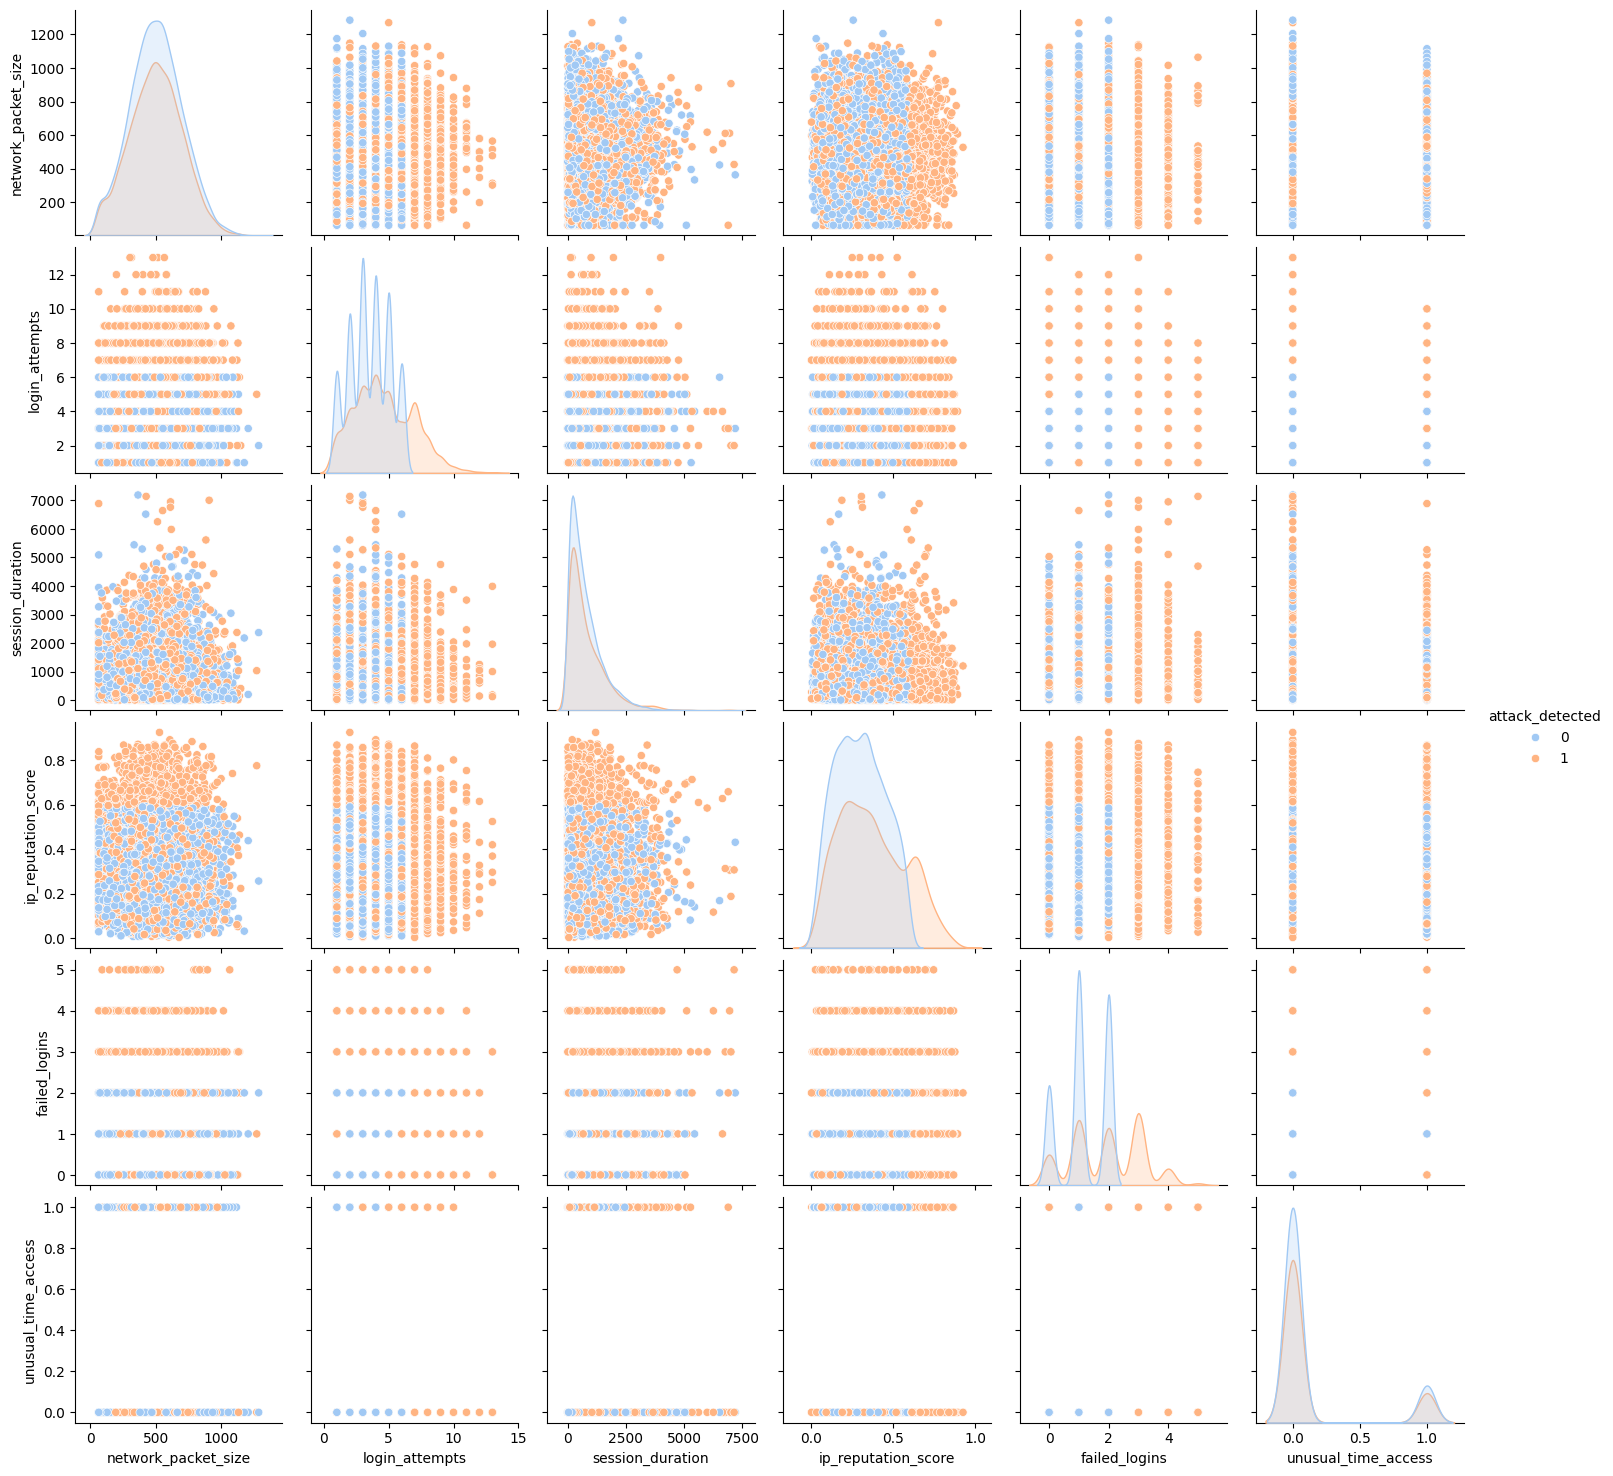

In [97]:
import seaborn as sns
sns.pairplot(data,hue="attack_detected", palette="pastel")

In [98]:
# 1.3 – Define alvo e remove identificador
target = "attack_detected"
id_col = "session_id"
if id_col in data.columns:
    data = data.drop(columns=[id_col])

In [99]:
# 1.4 – Separa X e y
X = data.drop(columns=[target])
y = data[target].astype(int)   # garante binário 0/1

In [100]:
# 1.5 – Olhar distribuição da classe
print("Distribuição da classe (y):")
print(y.value_counts(normalize=True).round(3))

Distribuição da classe (y):
attack_detected
0    0.553
1    0.447
Name: proportion, dtype: float64


In [101]:
# 2.1 – Identifica tipos
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

In [102]:
# 2.2 – Pipelines por tipo
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Atenção à compatibilidade: em versões recentes do sklearn, use 'sparse_output=False' em vez de 'sparse=False'.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

In [103]:
# 2.3 – ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ],
    remainder="drop"
)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (7629, 9)  Test size: (1908, 9)


In [105]:
# 4.1 – Dicionário de modelos
models = {
    "LogReg": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
    ]),
    "RandomForest": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
    ]),
    "SVM": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
    ]),
    "MLP": Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", MLPClassifier(hidden_layer_sizes=(100,), activation="relu", max_iter=300, random_state=42))
    ])
}

In [ ]:
# 4.2 – Validação cruzada com múltiplas métricas
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for name, pipe in models.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {
        "model": name,
        "acc_mean": np.mean(scores["test_accuracy"]),
        "acc_std": np.std(scores["test_accuracy"]),
        "prec_mean": np.mean(scores["test_precision"]),
        "recall_mean": np.mean(scores["test_recall"]),
        "f1_mean": np.mean(scores["test_f1"])
    }
    cv_results.append(row)

cv_df = pd.DataFrame(cv_results).sort_values(by="f1_mean", ascending=False)
cv_df

In [ ]:
def plot_confusion_matrix(cm, class_names=("0","1"), title="Matriz de Confusão"):
    fig = plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.tight_layout()
    plt.show()


In [ ]:
# 5.1 – Ajusta cada modelo e avalia em teste
test_reports = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, class_names=("Sem Ataque","Ataque"), title=f"Matriz de Confusão – {name}")
    test_reports[name] = {
        "report": classification_report(y_test, y_pred, output_dict=True),
        "cm": cm
    }

In [ ]:
r = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

imp_df.head(15)


In [ ]:
# Plot Top-15
top = imp_df.head(15).iloc[::-1]  # invertido para plot "de baixo para cima"
plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["importance_mean"])
plt.title("Permutation Importance (features originais) – RF afinada")
plt.xlabel("Importância média")
plt.tight_layout()
plt.show()

In [ ]:
# Convert all columns with data type 'object' to 'category' data type.
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# encode all columns that are not of type integer or float (i.e., categorical columns)
for col in data.select_dtypes(exclude=['int64', 'float64']).columns:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
sns.heatmap(data.corr(), annot=True, fmt=".2f",  cmap="Accent" , linewidth=.9, annot_kws={"size": 8})
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()